In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

## Run SEAM Model

SEAM model generate CAM (Class Activation Map) and process to get segmentation result

In [13]:
%%bash 
cd /content/drive/MyDrive/AIProject/SEAM/SEAM
rm demo/cams/*
python infer_SEAM.py --weights resnet38_SEAM.pth --infer_list voc12/demo.txt \
  --voc12_root /content/drive/MyDrive/AIProject/SEAM/demo \
  --out_cam /content/drive/MyDrive/AIProject/SEAM/demo/cams

0
1
2
3
4
5
6
7
8


rm: cannot remove 'demo/cams/*': No such file or directory
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [14]:
## Visualize cam
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt


def load_np(predict_file):
    predict_dict = np.load(predict_file, allow_pickle=True).item()
    h, w = list(predict_dict.values())[0].shape
    tensor = np.zeros((21,h,w),np.float32)
    for key in predict_dict.keys():
        tensor[key+1] = predict_dict[key]
    tensor[0,:,:] = 0.26
    predict = np.argmax(tensor, axis=0).astype(np.uint8)
    return predict, tensor

def color_pro(pro, img=None, mode='hwc'):
	H, W = pro.shape
	pro_255 = (pro*255).astype(np.uint8)
	pro_255 = np.expand_dims(pro_255,axis=2)
	color = cv2.applyColorMap(pro_255,cv2.COLORMAP_JET)
	color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
	if img is not None:
		rate = 0.5
		if mode == 'hwc':
			assert img.shape[0] == H and img.shape[1] == W
			color = cv2.addWeighted(img,rate,color,1-rate,0)
		elif mode == 'chw':
			assert img.shape[1] == H and img.shape[2] == W
			img = np.transpose(img,(1,2,0))
			color = cv2.addWeighted(img,rate,color,1-rate,0)
			color = np.transpose(color,(2,0,1))
	else:
		if mode == 'chw':
			color = np.transpose(color,(2,0,1))	
	return color

def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap


In [15]:
root = '/content/drive/MyDrive/AIProject/SEAM/demo'
path = os.path.join(root, 'JPEGImages')
mask_path = os.path.join(root, 'cams')  
cmap = color_map()

for name in os.listdir(mask_path):
    print(name)
    fp = os.path.join(mask_path, name)
    im_path = os.path.join(path, name[:-3]+'jpg')
    img = cv2.imread(im_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask, tensor = load_np(fp)
    segment_map = cmap[mask]
    tensor = np.max(tensor.transpose(1, 2, 0), -1)
    cam_map = color_pro(tensor, img)
#     segment_map = cv2.cvtColor(segment_map, cv2.COLOR_BGR2RGB)
    viz_map = np.concatenate([img, cam_map, segment_map], 1)
    plt.figure(figsize=(15, 15))
    plt.imshow(viz_map)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Run Attention Unet Model

Run SEAM on 10k augmentation images of PascalVOC12, have corresponding 10k pseudo-labels

Attention Unet trained on this "pseudo" dataset, the purpose of this step is: 
- Get better segmentation result
- Prove that SEAM and other weakly-supervise models has ability to generate good enough segmentation pseudo label even though no segmentation label provided in training.

In [16]:
import tensorflow as tf
import cv2
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [17]:
root = '/content/drive/MyDrive/AIProject/SEAM/Unet'
json = os.path.join(root, 'model_1/model.json')
h5 = os.path.join(root, 'model_1/weights.92_1.171.h5')
with open(json, 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
model.load_weights(h5)

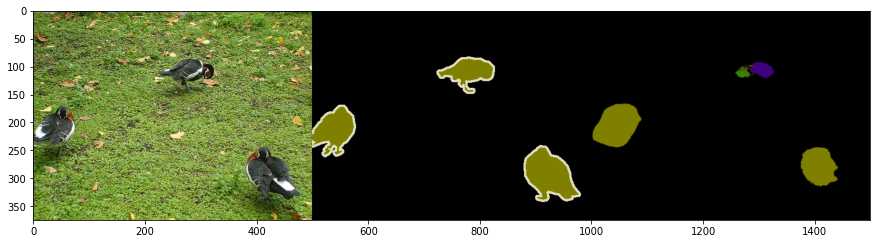

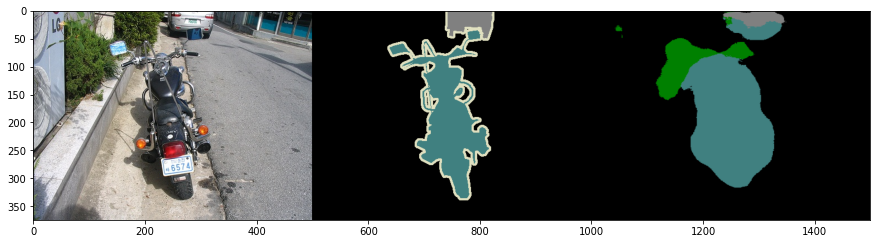

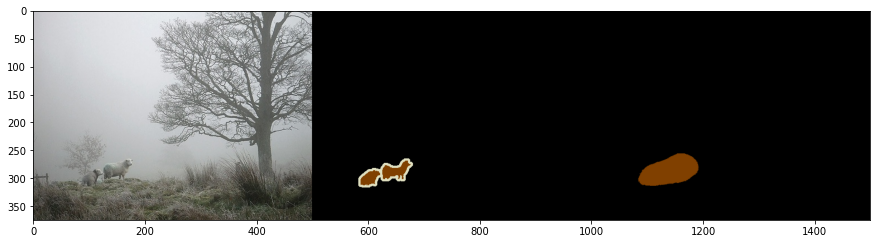

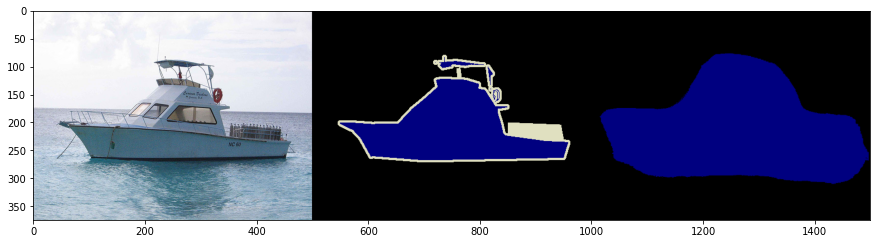

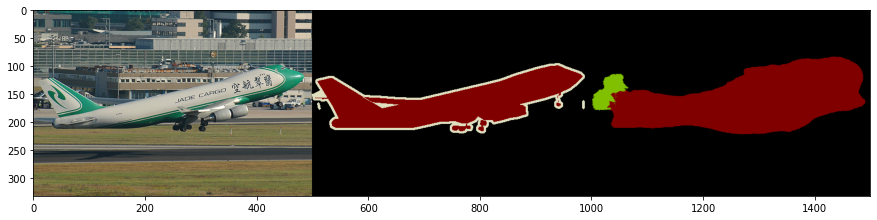

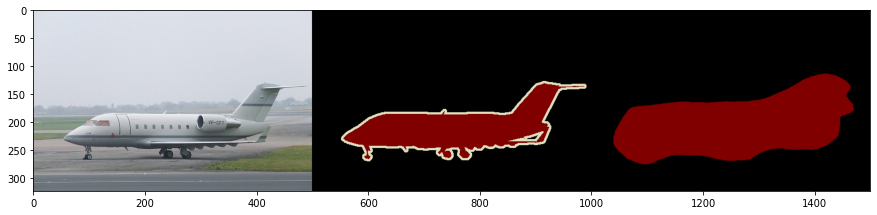

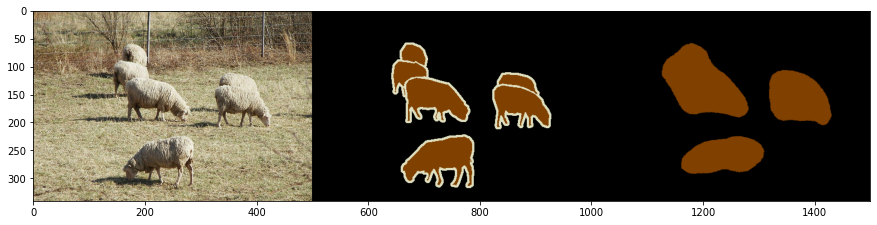

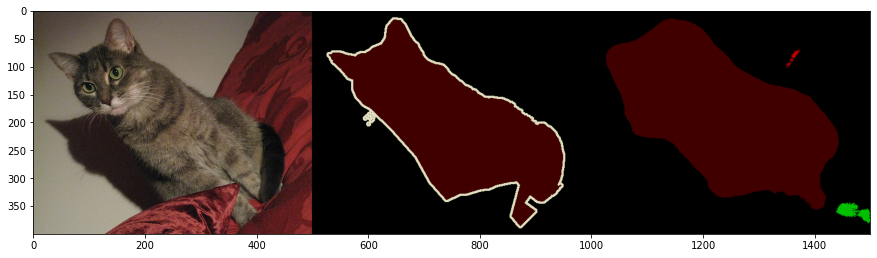

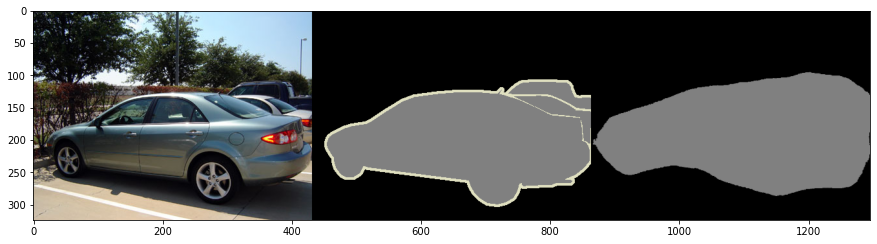

In [18]:
root = '/content/drive/MyDrive/AIProject/SEAM/demo'
path = os.path.join(root, 'JPEGImages')
save_path = os.path.join(root, 'predicts')
im_size = (448, 448)
for name in os.listdir(path):
    fp = os.path.join(path, name)
    label_path = os.path.join(root, 'labels', name[:-4] + '.png')
    src_img = cv2.imread(fp)
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    h, w = src_img.shape[:2]
    img = cv2.resize(src_img.copy(), (im_size[1], im_size[0]))
    img = img / 255.0
    tensor = tf.expand_dims(img, 0)
    s = time()
    mask = model(tensor)[0].numpy()#.astype('uint8')
    mask[0,:,:] = 0.26
    mask = np.argmax(mask, -1)
    segment_map = cmap[mask]
    segment_map = cv2.resize(segment_map, (w, h))
    label = cv2.imread(label_path)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
    viz_map = np.concatenate([src_img, label, segment_map], 1) 
    plt.figure(figsize=(15, 15))
    plt.imshow(viz_map)
    plt.show()
